In [2]:
import torch
from random import randint
from utilities import chordUtil
from utilities import dataImport
from utilities.chordUtil import *
from utilities.dataImport import *
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
import sys
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [4]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print("use_cuda")
print(use_cuda)
#use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda
True


In [5]:
# Init
lenSeq = 16
#lenSeq = 48
alpha = 'a0'
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
#filenames.remove(".DS_Store")
dictChord, listChord = chordUtil.getDictChord(eval(alpha))
print(len(dictChord))
print(dictChord)
print(listChord)

25
{'A#:maj': 0, 'C:min': 1, 'F:min': 2, 'F:maj': 3, 'B:min': 4, 'G:min': 5, 'C:maj': 6, 'D:maj': 7, 'N': 8, 'E:maj': 9, 'G#:maj': 10, 'E:min': 11, 'D#:maj': 12, 'B:maj': 13, 'C#:maj': 14, 'F#:min': 15, 'A:maj': 16, 'G#:min': 17, 'C#:min': 18, 'F#:maj': 19, 'G:maj': 20, 'D#:min': 21, 'A#:min': 22, 'A:min': 23, 'D:min': 24}
['A#:maj', 'C:min', 'F:min', 'F:maj', 'B:min', 'G:min', 'C:maj', 'D:maj', 'N', 'E:maj', 'G#:maj', 'E:min', 'D#:maj', 'B:maj', 'C#:maj', 'F#:min', 'A:maj', 'G#:min', 'C#:min', 'F#:maj', 'G:maj', 'D#:min', 'A#:min', 'A:min', 'D:min']


In [6]:
# Create datasets
files_train ,files_test = train_test_split(filenames,test_size=0.7)
dataset_train = dataImport.ChordSeqDataset(files_train, rootname, alpha, dictChord, lenSeq)
dataset_test = dataImport.ChordSeqDataset(files_test, rootname, alpha, dictChord, lenSeq)


In [7]:
# Create generators
params = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(dataset_train, **params)
testing_generator = data.DataLoader(dataset_test, **params)


In [8]:
class MYLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,dropout):
        super(MYLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout)
        #self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.last_fully_connected = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_batch):
        output, (hidden, cell_state) = self.lstm1(input_batch)
        #output, (hidden, cell_state) = self.lstm2(output,(hidden, cell_state))
        #print(output.size(), hidden.size(), cell_state.size())
        output = output[:,-1,:]
        #hidden = hidden[-1,:,:]
        #cell_state = cell_state[-1,:,:]
        #output = torch.cat((output,hidden,cell_state),1)
        output = self.last_fully_connected(output)
        output = self.softmax(output)

        return output

## Il reste à utiliser cette matrice pour pondérer les erreurs de prévisions

In [9]:
from utilities import chordsDistances
from utilities.chordsDistances import getPaulMatrix
from utilities import remapChordsToBase
from utilities.remapChordsToBase import remapPaulToTristan

M = chordsDistances.getPaulMatrix()
M = remapChordsToBase.remapPaulToTristan(M,'a0')
M_tensor = torch.tensor(M, dtype = torch.float).to(device)
print(M)

[[ 0.  3.  4.  3. 10.  2.  6.  8.  1. 10.  6.  9.  3.  9.  7.  9.  9.  7.
   8.  8.  7.  6.  5.  8.  5.]
 [ 3.  0.  3.  4.  9.  3.  5.  7.  1.  9.  5.  8.  2. 10.  8. 10.  8.  8.
   9.  9.  6.  7.  6.  7.  6.]
 [ 4.  3.  0.  5. 10.  6.  6.  8.  1. 10.  2.  9.  3.  9.  5.  9.  9.  7.
   8.  8.  7.  6.  3.  8.  7.]
 [ 3.  4.  5.  0.  9.  3.  3.  7.  1.  9.  7.  8.  6. 10.  8. 10.  8.  8.
   9.  9.  6.  7.  6.  5.  2.]
 [10.  9. 10.  9.  0.  8.  8.  2.  1.  4.  8.  3.  9.  5.  7.  3.  3.  7.
   6.  6.  5.  8.  9.  6.  7.]
 [ 2.  3.  6.  3.  8.  0.  4.  6.  1.  8.  8.  7.  5.  9.  9.  9.  7.  9.
  10. 10.  5.  8.  7.  6.  3.]
 [ 6.  5.  6.  3.  8.  4.  0.  6.  1.  8.  8.  5.  7.  9.  9.  9.  7.  9.
  10. 10.  3.  8.  7.  2.  3.]
 [ 8.  7.  8.  7.  2.  6.  6.  0.  1.  6. 10.  3.  9.  7.  9.  5.  3.  9.
   8.  8.  3. 10.  9.  4.  5.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.]
 [10.  9. 10.  9.  4.  8.  8.  6.  1.  0.  8.  5.  9.  

In [10]:
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
alphabet = "a0"
dictChord, listChord = chordUtil.getDictChord(eval(alphabet))

#dictChord["C:maj"]

In [15]:
def train(local_batch, local_labels):

    optimizer.zero_grad()
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)    
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    
    output = lstm_nn(local_batch)
    #print("outputsize")
    #print(output.size())
    #print("locallabels size")
    #print(local_labels.size())
    loss_mult_coeff = 0
    for i in range(len(local_batch)):
        #first = torch.matmul(M_tensor,local_labels[i])
        #third = torch.matmul(output[i],first)
        #fourth = third.item()
        loss_mult_coeff += torch.matmul(M_tensor,local_labels[i])[torch.argmax(output[i])]
        #loss_mult_coeff += (torch.transpose(output[i],0,1).dot(M_tensor).dot(local_labels[i])).item()
    loss_mult_coeff = loss_mult_coeff/len(local_batch)
    #print(loss_mult_coeff)
    
    for i in range(len(local_batch)):
        #print(output[i].size(), local_labels[i].size())
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    
    #M_tensor.dot
    #print(output[0])
    #print(local_labels[0])
    loss = loss_mult_coeff * criterion(output, local_labels_argmax)
    #print("loss")
    #print(loss)
    #loss = criterion(output, local_labels)

    #print(output.size(),local_labels.size())
    
    loss.backward()
    optimizer.step()


    return output, loss.item() / len(local_batch), correct_guess, wrong_guess

In [12]:
def test(local_batch, local_labels):
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = lstm_nn(local_batch)

    
    for i in range(len(local_batch)):
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    return output, loss.item() / len(local_batch), correct_guess, wrong_guess
    

# Attention

Ici, soit on crée un nouveau réseau, soit on charge un réseau déjà entraîné.

Réseaux déjà entraînés (si non précisé, dropout = 0.1) :

    - "models/lstm_2layers_256blocks_a0.pt"
    - "models/lstm_2layers_256blocks_a1.pt"
    - "models/lstm_2layers_512blocks_a1_dropout=0.pt"
    - "models/lstm_2layers_512blocks_a1.pt"
    - "models/lstm_2layers_512blocks_a1.pt"
    
(ce notebook n'est plus maintenu, et ainsi les réseaux déjà entraînés ne le sont peut être plus)

In [18]:
#Init new model

#lstm_nn = nn.LSTM(len(dictChord), len(dictChord), num_layers = lenSeq*5, batch_first = True, dropout = 0.1).to(device)
lstm_nn = MYLSTM(input_size = len(dictChord), hidden_size = 256, num_layers = 2, dropout = 0).to(device)


In [10]:
# Or Load previous model
lstm_nn = torch.load("models/lstm_2layers_512blocks_a1.pt").to(device)

In [23]:
save = False
save_path = "models/lstm_2layers_512blocks_a1.pt"
lstm_nn.train(mode=True)



all_losses = []
test_losses = []
total_loss = 0 # Reset every plot_every iters
test_loss = 0

correct_guess_train, wrong_guess_train, correct_guess_test, wrong_guess_test = 0, 0, 0, 0
accuracy_test = []
accuracy_train = []

update_plot = False


start = time.time()

optimizer = torch.optim.Adam(lstm_nn.parameters(), lr = 1e-4)
#print(lstm_nn.parameters())
#optimizer = torch.optim.SGD(lstm_nn.parameters(), lr = 5e2, momentum=0.9)


#criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


print_every = 5
plot_every = 5
max_epochs = 50


# Begin training
print("Start training")
for epoch in range(1, max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        output, loss, correct_guess, wrong_guess = train(local_batch, local_labels)
        #print(loss)
        total_loss += loss
        correct_guess_train += correct_guess
        wrong_guess_train += wrong_guess

    if epoch % print_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        print('%s (%d %d%%) train, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        all_losses.append(total_loss / (plot_every ))
        accuracy_train.append(accuracy*100)
        total_loss = 0
        correct_guess_train, wrong_guess_train = 0, 0

        

    # Testing
    for local_batch, local_labels in testing_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output, loss, correct_guess, wrong_guess  = test(local_batch, local_labels)
        test_loss +=loss
        
        correct_guess_test += correct_guess
        wrong_guess_test += wrong_guess
        

    if epoch % print_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        print('%s (%d %d%%) test, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        test_losses.append(test_loss / (plot_every ))
        accuracy_test.append(accuracy*100)
        test_loss = 0
        correct_guess_test, wrong_guess_test = 0, 0
        
        
#experimental feature : plot in realtime
    if update_plot and plot_every ==1:
        if epoch == 1:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            print(range(epoch), accuracy_test)
            li, = ax.plot(epoch, accuracy_test)
            
            ax.relim() 
            ax.autoscale_view(True,True,True)
            fig.canvas.draw()
            plt.show(block=False)
        time.sleep(0.01)
        li.set_data(list(range(epoch)),accuracy_test)
        time.sleep(0.01)
        fig.canvas.draw()
        
print("Finished training")
if save:
    torch.save(lstm_nn, save_path)
    


Start training
0m 5s (5 10%) train, loss : 0.0257, accuracy : 23.6108%
0m 6s (5 10%) test, loss : 0.0055, accuracy : 22.4987%
0m 12s (10 20%) train, loss : 0.0272, accuracy : 22.6495%
0m 13s (10 20%) test, loss : 0.0056, accuracy : 23.2614%
0m 19s (15 30%) train, loss : 0.0268, accuracy : 22.6964%
0m 20s (15 30%) test, loss : 0.0054, accuracy : 23.2313%
0m 26s (20 40%) train, loss : 0.0251, accuracy : 24.4783%
0m 27s (20 40%) test, loss : 0.0056, accuracy : 24.6262%
0m 33s (25 50%) train, loss : 0.0243, accuracy : 25.0645%
0m 34s (25 50%) test, loss : 0.0054, accuracy : 25.1279%
0m 40s (30 60%) train, loss : 0.0242, accuracy : 25.4631%
0m 41s (30 60%) test, loss : 0.0055, accuracy : 25.5595%
0m 47s (35 70%) train, loss : 0.0217, accuracy : 26.5651%
0m 48s (35 70%) test, loss : 0.0055, accuracy : 26.3121%
0m 54s (40 80%) train, loss : 0.0250, accuracy : 25.5803%
0m 55s (40 80%) test, loss : 0.0053, accuracy : 26.1716%
1m 1s (45 90%) train, loss : 0.0227, accuracy : 25.4631%
1m 2s (45 90

Loss :


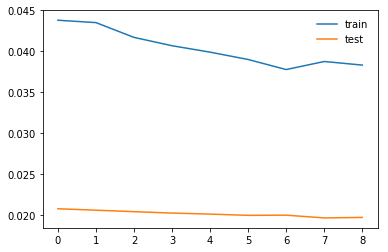

Accuracy :


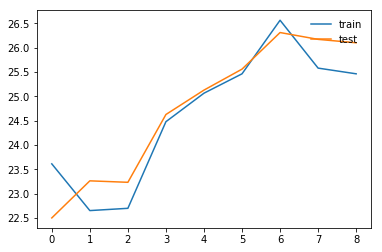

In [24]:
print("Loss :")
plt.figure()
plt.plot(all_losses, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(test_losses, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()
!
print("Accuracy :")
plt.figure()
plt.plot(accuracy_train, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(accuracy_test, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

# Test avec une grille blues

C'est un peu nul, j'ai l'impression que plus le réseau est entraîné, plus il renvoie des trucs nuls...

In [25]:
if lenSeq == 16:

    test_sequence = ["C:maj","F:maj","C:maj","C:maj",
                     "F:maj","F:maj","C:maj","C:maj",
                     "G:maj","F:maj","C:maj","G:maj",
                     "C:maj","C:maj","F:maj","G:maj"]
    if alpha == 'a5':
        test_sequence = ["C:maj","D:min","D:maj","E:min",
                         "E:min","E:maj","F:min","F:maj",
                         "G:min","G:maj","A:min","A:maj",
                         "B:min","B:maj","C:min","C:maj"]

if lenSeq == 48:
    test_sequence = ["C:maj","C:maj","C:maj","C:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                    "F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                    "G:maj","G:maj","G:maj","G:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","G:maj","G:maj","G:maj","G:maj"]
    


test_sequence = test_sequence[0:lenSeq]
test_sequence_tensor = torch.zeros(1, len(test_sequence), len(dictChord)).to(device)
last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
test_sequence_tensor.requires_grad = False
last_chords_output.requires_grad = False
for t in range(len(test_sequence)):
    test_sequence_tensor[0, t, dictChord[test_sequence[t]]] = 1
    if t != len(test_sequence)-1 :
        last_chords_output[0, t-1, dictChord[test_sequence[t]]] = 1



In [29]:
generation_lenght = 120

generated_sequence = [0 for i in range(generation_lenght)]
generated_sequence[0:lenSeq] = test_sequence

lstm_nn.train(mode=False)
softmax = nn.Softmax(dim=0)

#Experimental
sampling = False
from random import choices



for t in range(generation_lenght-lenSeq):
    if t == 0:
        output_probability = lstm_nn(test_sequence_tensor)
        
        if sampling:
            choice = choices(range(len(listChord)),softmax(output_probability[0]))[0]
            generated_sequence[t+lenSeq] = listChord[choice]
            last_chords_output[0, lenSeq-1, choice] = 1
            
        else: 
            generated_sequence[t+lenSeq] = listChord[torch.argmax(output_probability).item()]
            last_chords_output[0, lenSeq-1, torch.argmax(output_probability).item()] = 1
            
            
    else:
        
        last_chords_output.to(device)        
        output_probability = lstm_nn(last_chords_output)
        last_chords_output[0,0:lenSeq-1] = last_chords_output[0,1:lenSeq]
        
        if sampling:
            choice = choices(range(len(listChord)),softmax(output_probability[0]))[0]
            generated_sequence[t+lenSeq] = listChord[choice]
            last_chords_output[0, lenSeq-1, choice] = 1
            
        else:
            last_chords_output[0, lenSeq-1, torch.argmax(output_probability).item()] = 1
            generated_sequence[t+lenSeq] = listChord[torch.argmax(output).item()]
    
        


        

        
for i in range(generation_lenght):
    if i%4 == 0:
        print(generated_sequence[i:i+4])
    if i == lenSeq-1 :
        print("generated :")

['C:maj', 'F:maj', 'C:maj', 'C:maj']
['F:maj', 'F:maj', 'C:maj', 'C:maj']
['G:maj', 'F:maj', 'C:maj', 'G:maj']
['C:maj', 'C:maj', 'F:maj', 'G:maj']
generated :
['G:maj', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min', 'G:min']
['G:min', 'G:min', 'G:min'